# Salary Prediction using XGBoosting

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style='darkgrid')

### Reading and EDA

In [7]:
df = pd.read_csv("adult 3.csv")

In [8]:
df

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
48838,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
48839,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
48840,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [9]:
df.replace('?',np.nan,inplace=True)

In [10]:
df.shape

(48842, 15)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   fnlwgt           48842 non-null  int64 
 3   education        48842 non-null  object
 4   educational-num  48842 non-null  int64 
 5   marital-status   48842 non-null  object
 6   occupation       46033 non-null  object
 7   relationship     48842 non-null  object
 8   race             48842 non-null  object
 9   gender           48842 non-null  object
 10  capital-gain     48842 non-null  int64 
 11  capital-loss     48842 non-null  int64 
 12  hours-per-week   48842 non-null  int64 
 13  native-country   47985 non-null  object
 14  income           48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


### Removing Duplicates

In [12]:
num_of_duplicates = df.duplicated().sum()
if num_of_duplicates>0:
    df.drop_duplicates(inplace=True,ignore_index=True,keep="first")
    print(f"The number of duplicates rows was {num_of_duplicates} and now 0")
else :
    print("There is no duplicates")

The number of duplicates rows was 52 and now 0


### Here we can see that there are null values in workclass, occupation, native-country

In [13]:
(round(df.isna().sum()*100/len(df),2)).sort_values(ascending=False)

occupation         5.75
workclass          5.73
native-country     1.75
fnlwgt             0.00
education          0.00
educational-num    0.00
age                0.00
marital-status     0.00
relationship       0.00
gender             0.00
race               0.00
capital-gain       0.00
capital-loss       0.00
hours-per-week     0.00
income             0.00
dtype: float64

In [14]:
# native-country column
df.dropna(subset=["native-country"],inplace=True,ignore_index=True)
# workclass column
df.fillna({"workclass":"Unknown"},inplace=True)
# Occupation column
df.loc[df["workclass"]=="Never-worked","occupation"]="No-job"
df.loc[df["workclass"]=="Unknown","occupation"]="Unknown-job"

In [15]:
print(f"The number of missing data now is: {df.isna().sum().sum()}")

The number of missing data now is: 0


### Handling Outliers

In [16]:
def outliers_handler(real_data:pd.DataFrame(),col_name:str)->pd.DataFrame():
    data=real_data.copy()
    q1 = np.percentile(data[col_name],25)
    q3 = np.percentile(data[col_name],75)
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = (data[col_name]>upper_bound) | (data[col_name]<lower_bound)
    num_of_outliers = len(data[outliers])
    if num_of_outliers <= len(data)*0.1:
        data = data[~outliers]
        print("Outliers dropped")
    else:
        data.loc[data[col_name]>upper_bound,col_name] = upper_bound
        data.loc[data[col_name]<lower_bound,col_name] = lower_bound
        print("Outliers replaced")
    return data

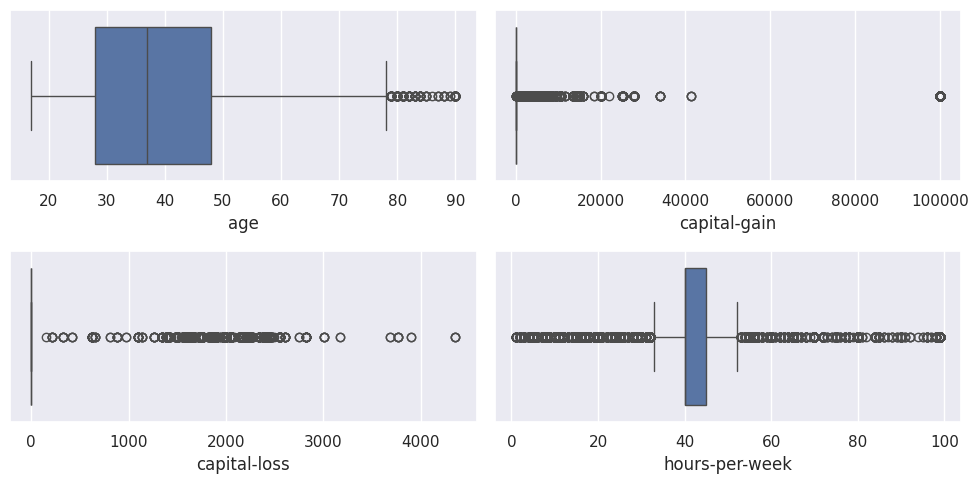

In [17]:
plt.figure(figsize=(10,5))
i=1
for col in df.select_dtypes(exclude="object").columns :
    if col in ["fnlwgt","educational-num"]:
        continue
    plt.subplot(2,2,i)
    sns.boxplot(data=df,x=col)
    i+=1
plt.tight_layout()
plt.show()

In [18]:
for i in ["age","hours-per-week"]:
    df=outliers_handler(df,i)

Outliers dropped
Outliers replaced


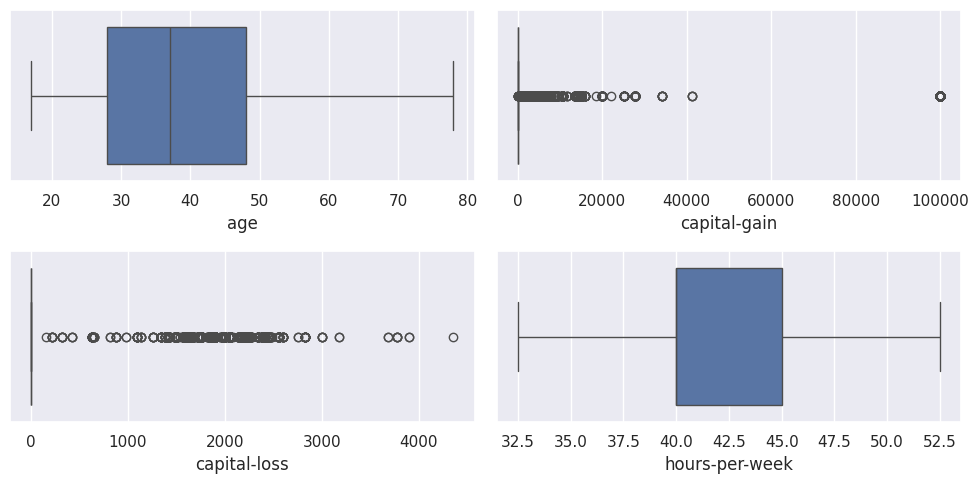

In [19]:
plt.figure(figsize=(10,5))
i=1
for col in df.select_dtypes(exclude="object").columns :
    if col in ["fnlwgt","educational-num"]:
        continue
    plt.subplot(2,2,i)
    sns.boxplot(data=df,x=col)
    i+=1
plt.tight_layout()
plt.show()

### Feature Engineering and Feature Selection

In [20]:
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,PolynomialFeatures

df2=df.copy()
le=LabelEncoder()
for i in df2.select_dtypes(include="object"):
    df2[i]=le.fit_transform(df2[i])

In [21]:
df2

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,3,226802,1,7,4,6,3,2,1,0,0,40.0,38,0
1,38,3,89814,11,9,2,4,0,4,1,0,0,50.0,38,0
2,28,1,336951,7,12,2,11,0,4,1,0,0,40.0,38,1
3,44,3,160323,15,10,2,6,0,2,1,7688,0,40.0,38,1
4,18,7,103497,15,10,4,15,3,4,0,0,0,32.5,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47929,27,3,257302,7,12,2,13,5,4,0,0,0,38.0,38,0
47930,40,3,154374,11,9,2,6,0,4,1,0,0,40.0,38,1
47931,58,3,151910,11,9,6,0,4,4,0,0,0,40.0,38,0
47932,22,3,201490,11,9,4,0,3,4,1,0,0,32.5,38,0


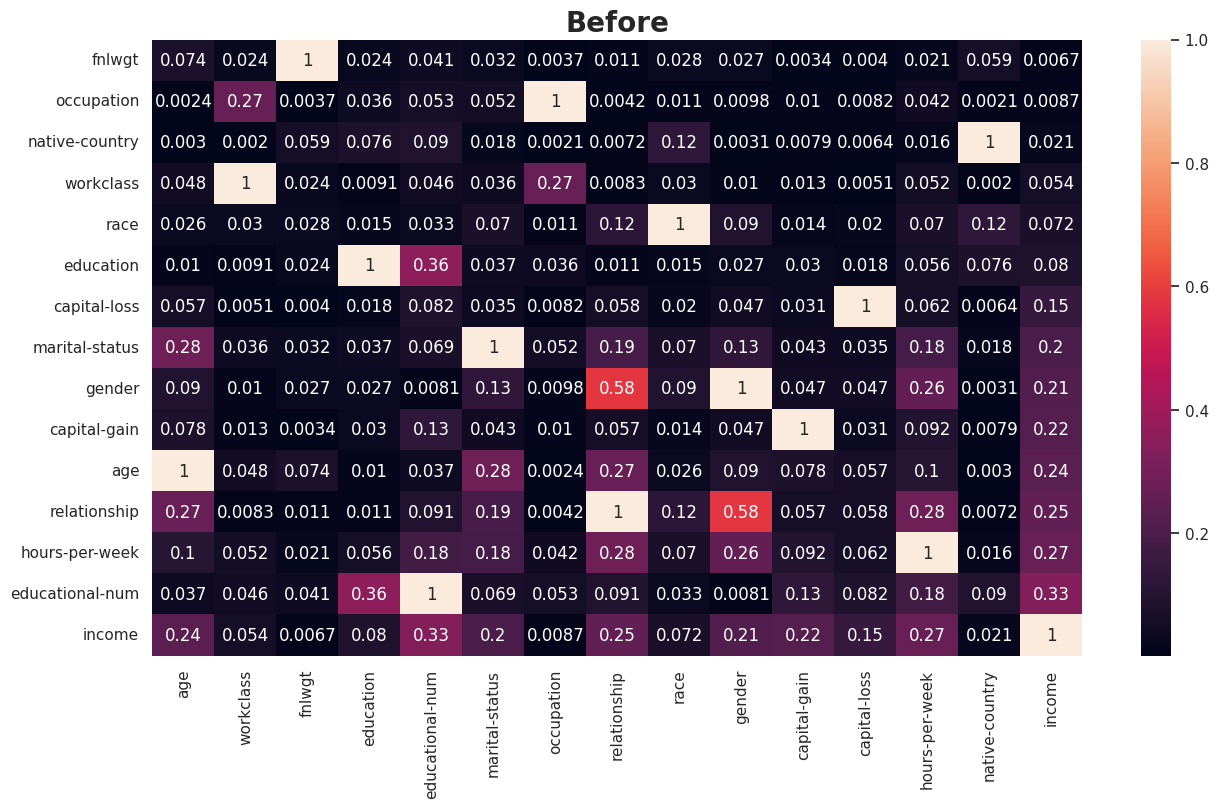

In [22]:
plt.figure(figsize=(15,8))
plt.title("Before",fontsize=20,weight="bold")
sns.heatmap(df2.corr().abs().sort_values("income"),annot=True)
plt.show()

In [23]:
work=pd.DataFrame(round(df.workclass.value_counts()*100/len(df),2))
work

,count
workclass,
Private,69.50
Self-emp-not-inc,7.87
Local-gov,6.47
Unknown,5.66
State-gov,4.08
Self-emp-inc,3.42
Federal-gov,2.94
Without-pay,0.04
Never-worked,0.02


In [24]:
df.loc[(df["workclass"]!="Private"),"workclass"]="Others"

In [25]:
occ=pd.DataFrame(round(df.occupation.value_counts()*100/len(df),2))
display(occ)

,count
occupation,
Craft-repair,12.58
Prof-specialty,12.52
Exec-managerial,12.46
Adm-clerical,11.56
Sales,11.28
Other-service,10.03
Machine-op-inspct,6.20
Unknown-job,5.66
Transport-moving,4.84


In [26]:
li=occ.tail(10).index.tolist()
df.loc[(df["occupation"].isin(li)),"occupation"]="Others"

In [27]:
df["educational-num"].value_counts()

educational-num
9     15505
10    10684
13     7780
14     2566
11     2032
7      1794
12     1574
6      1364
4       902
15      797
5       743
8       631
16      558
3       483
2       231
1        80
Name: count, dtype: int64

In [28]:
ed=pd.DataFrame(round(df.education.value_counts()*100/len(df),2))
ed

,count
education,
HS-grad,32.49
Some-college,22.39
Bachelors,16.30
Masters,5.38
Assoc-voc,4.26
11th,3.76
Assoc-acdm,3.30
10th,2.86
7th-8th,1.89


In [29]:
li=ed.tail(12).index.tolist()
df.loc[(df["education"].isin(li)),"education"]="Others"

In [30]:
marital=pd.DataFrame(round(df["marital-status"].value_counts()*100/len(df),2))
marital

,count
marital-status,
Married-civ-spouse,45.81
Never-married,33.01
Divorced,13.72
Separated,3.15
Widowed,3.00
Married-spouse-absent,1.23
Married-AF-spouse,0.08


In [31]:
li=marital.tail(5).index.tolist()
df.loc[(df["marital-status"].isin(li)),"marital-status"]="Others"

In [32]:
race=pd.DataFrame(round(df["race"].value_counts()*100/len(df),2))
race

,count
race,
White,85.81
Black,9.52
Asian-Pac-Islander,2.90
Amer-Indian-Eskimo,0.98
Other,0.80


In [33]:
li=race.tail(3).index.tolist()
df.loc[(df["race"].isin(li)),"race"]="Others"

In [34]:
le =LabelEncoder()
for i in df.select_dtypes(include="object"):
    df[i]=le.fit_transform(df[i])

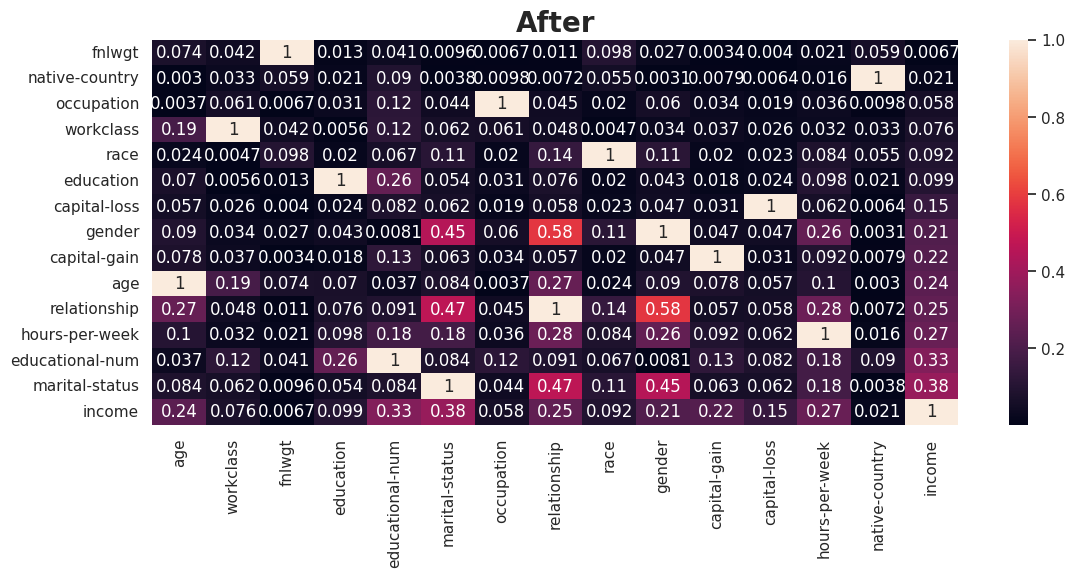

In [35]:
plt.figure(figsize=(13,5))
plt.title("After",fontsize=20,weight="bold")
sns.heatmap(df.corr().abs().sort_values("income"),annot=True)
plt.show()

In [36]:
df.drop(["fnlwgt","native-country","occupation","workclass","race","education","gender"],axis=1,inplace=True)

In [48]:
X=df.drop(["income",'capital-gain','capital-loss'],axis=1)
y=df.income
X

,age,educational-num,marital-status,relationship,hours-per-week
0,25,7,1,3,40.0
1,38,9,0,0,50.0
2,28,12,0,0,40.0
3,44,10,0,0,40.0
4,18,10,1,3,32.5
...,...,...,...,...,...
47929,27,12,0,5,38.0
47930,40,9,0,0,40.0
47931,58,9,2,4,40.0
47932,22,9,1,3,32.5


In [49]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X,y,train_size=0.8,random_state=42)

### XGBoosting

### Hyperparamter Tuning

In [50]:
from xgboost import XGBClassifier 
from scipy.optimize import differential_evolution

par={
    "max_depth": (3,12),
    "n_estimators":(100,200),
   "min_impurity_decrease":(0,0.1)
}


def evaluation_func(par):
    max_depth=int(par[0])
    n_estimators=int(par[1])
    min_imputrity_decrease= float(par[2])
    clf=XGBClassifier(max_depth=max_depth,
                      n_estimators=n_estimators,
                      random_state=41,
                      min_impurity_decrease=min_imputrity_decrease)
    clf.fit(x_train,y_train)
    return -clf.score(x_test,y_test)

np.random.seed(41)
res = differential_evolution(evaluation_func
                             ,bounds=list(par.values()),
                             maxiter=15,
                             popsize=20,
                             mutation=0.9,
                             recombination=0.8)
print(f"Parameters: {res.x}\nScore: {-res.fun*100:.2f}")

Parameters: [5.80766634e+00 1.05553766e+02 7.12122547e-03]
Score: 82.86


### Model Training and Testing

In [51]:
xgb = XGBClassifier(max_depth=int(res.x[0]),
                    n_estimators=int(res.x[1]),
                    random_state=41,
                    min_impurity_decrease=float(res.x[2]))
xgb.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=None,
              min_impurity_decrease=0.007121225467314786, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=105,
              n_jobs=None, ...)

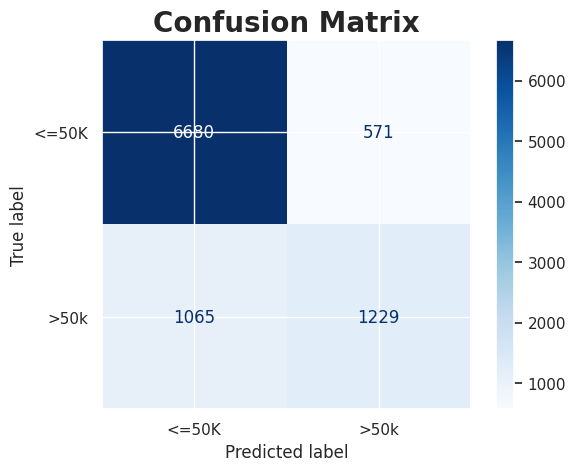

In [52]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

y_pred=xgb.predict(x_test)
matrix=confusion_matrix(y_test,y_pred)
figure=ConfusionMatrixDisplay(matrix,display_labels=["<=50K",">50k"])
figure.plot(cmap="Blues")
plt.title("Confusion Matrix",fontsize=20,weight="bold")
plt.show()

In [45]:
train_score=xgb.score(x_train,y_train)
test_score=xgb.score(x_test,y_test)
print(f"Train Score: {train_score*100:.2f}\nTest Score: {test_score*100:.2f}")
report=classification_report(y_test,y_pred)
print(report)

Train Score: 87.06
Test Score: 86.64
              precision    recall  f1-score   support

           0       0.89      0.95      0.91      7251
           1       0.78      0.62      0.69      2294

    accuracy                           0.87      9545
   macro avg       0.83      0.78      0.80      9545
weighted avg       0.86      0.87      0.86      9545



In [53]:
import joblib

# Save the trained XGBoost model
joblib.dump(xgb, "xgb_model.pkl")

['xgb_model.pkl']

In [56]:
%%writefile stream_app.py
import streamlit as st
import pandas as pd
import numpy as np
import joblib

# Load the trained model
model = joblib.load("xgb_model.pkl")

st.set_page_config(page_title="Income Class Prediction", page_icon="💰", layout="centered")

st.title("💰 Income Class Prediction App")
st.markdown("Predict whether a person earns >50K or ≤50K based on census features.")

# Sidebar input
st.sidebar.header("Input Features")

# Feature 1: Age (numerical)
age = st.sidebar.slider("Age", 18, 90, 35)

# Feature 2: Education Level -> mapped to 'educational-num'
edu_map = {
    "Preschool": 1,
    "1st-4th": 2,
    "5th-6th": 3,
    "7th-8th": 4,
    "9th": 5,
    "10th": 6,
    "11th": 7,
    "12th": 8,
    "HS-grad": 9,
    "Some-college": 10,
    "Assoc-voc": 11,
    "Assoc-acdm": 12,
    "Bachelors": 13,
    "Masters": 14,
    "Prof-school": 15,
    "Doctorate": 16
}
education_label = st.sidebar.selectbox("Education Level", list(edu_map.keys()))
edu_num = edu_map[education_label]

# Feature 3: Marital Status (categorical -> encoded)
marital_status_map = {
    "Married-civ-spouse": 0,
    "Divorced": 1,
    "Never-married": 2,
    "Separated": 3,
    "Others": 4
}
marital_status_label = st.sidebar.selectbox("Marital Status", list(marital_status_map.keys()))
marital_status = marital_status_map[marital_status_label]

# Feature 4: Relationship (categorical -> encoded)
relationship_map = {
    "Husband": 0,
    "Not-in-family": 1,
    "Own-child": 2,
    "Unmarried": 3,
    "Wife": 4,
    "Others": 5
}
relationship_label = st.sidebar.selectbox("Relationship", list(relationship_map.keys()))
relationship = relationship_map[relationship_label]

# Feature 5: Hours per week (numerical)
hours_per_week = st.sidebar.slider("Hours per Week", 1, 99, 40)

# Build input DataFrame
input_df = pd.DataFrame({
    'age': [age],
    'educational-num': [edu_num],
    'marital-status': [marital_status],
    'relationship': [relationship],
    'hours-per-week': [hours_per_week]
})

st.write("### 🔎 Input Data")
st.write(input_df)

# Predict button
if st.button("Predict Income Class"):
    prediction = model.predict(input_df)
    label = ">50K" if prediction[0] == 1 else "≤50K"
    st.success(f"✅ Prediction: {label}")

# Batch prediction
st.markdown("---")
st.markdown("#### 📂 Batch Prediction")
uploaded_file = st.file_uploader("Upload a CSV file for batch prediction", type="csv")

if uploaded_file is not None:
    batch_data = pd.read_csv(uploaded_file)
    st.write("Uploaded data preview:", batch_data.head())

    required_columns = ['age', 'educational-num', 'marital-status', 'relationship', 'hours-per-week']
    if all(col in batch_data.columns for col in required_columns):
        batch_preds = model.predict(batch_data[required_columns])
        batch_data['PredictedClass'] = np.where(batch_preds == 1, '>50K', '≤50K')
        st.write("✅ Predictions:")
        st.write(batch_data.head())

        csv = batch_data.to_csv(index=False).encode('utf-8')
        st.download_button("Download Predictions CSV", csv, file_name='predicted_income.csv', mime='text/csv')
    else:
        st.error("❌ CSV is missing one or more required columns.")


Overwriting stream_app.py
